# Data Exploration for image dataset

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

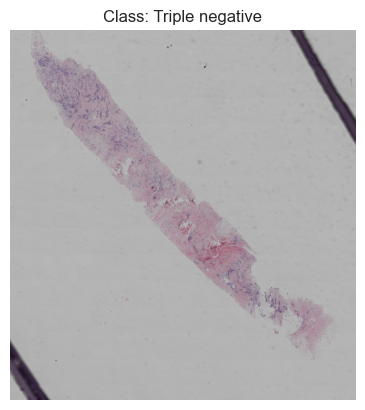

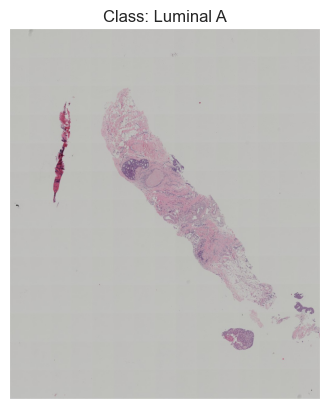

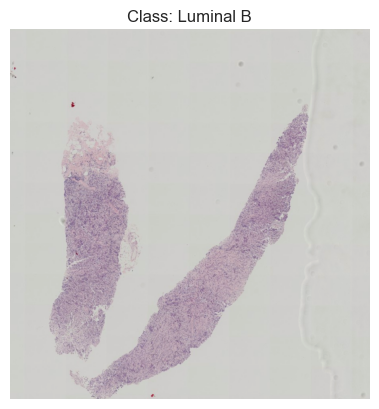

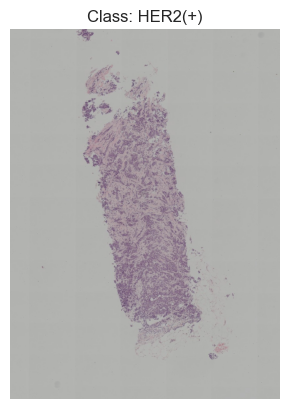

In [14]:
# Load image dataset
train_dir = 'data/train_data/'
test_dir = 'data/test_data/'
train_labels = pd.read_csv('data/train_labels.csv')

# Display sample images from each class
classes = train_labels['label'].unique()
for cls in classes:
    sample_image_path = train_dir + train_labels[train_labels['label'] == cls]['sample_index'].values[0]
    img = Image.open(sample_image_path)
    plt.imshow(img)
    plt.title(f'Class: {cls}')
    plt.axis('off')
    plt.show()

In [15]:
# Remove contaminated images from training data
import shutil
import os

# Parse the contaminated indices from the text file
contaminated_indices = []
with open('shrek_and_slimes.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line and line.isdigit():
            contaminated_indices.append(int(line))

print(f"Found {len(contaminated_indices)} contaminated samples to remove")

# Remove corresponding image and mask files
removed_count = 0
for idx in contaminated_indices:
    img_name = f'img_{idx:04d}.png'
    mask_name = f'mask_{idx:04d}.png'

    img_path = os.path.join(train_dir, img_name)
    mask_path = os.path.join(train_dir, mask_name)

    # Remove image if exists
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1

    # Remove mask if exists
    if os.path.exists(mask_path):
        os.remove(mask_path)
        removed_count += 1

print(f"Removed {removed_count} files from {train_dir}")

# Update train_labels by removing contaminated indices
train_labels = train_labels[~train_labels['sample_index'].str.extract(r'(\d+)')[0].astype(int).isin(contaminated_indices)]
print(f"Training labels updated: {len(train_labels)} samples remaining")

Found 249 contaminated samples to remove
Removed 498 files from data/train_data/
Training labels updated: 1163 samples remaining


<Axes: xlabel='label', ylabel='count'>

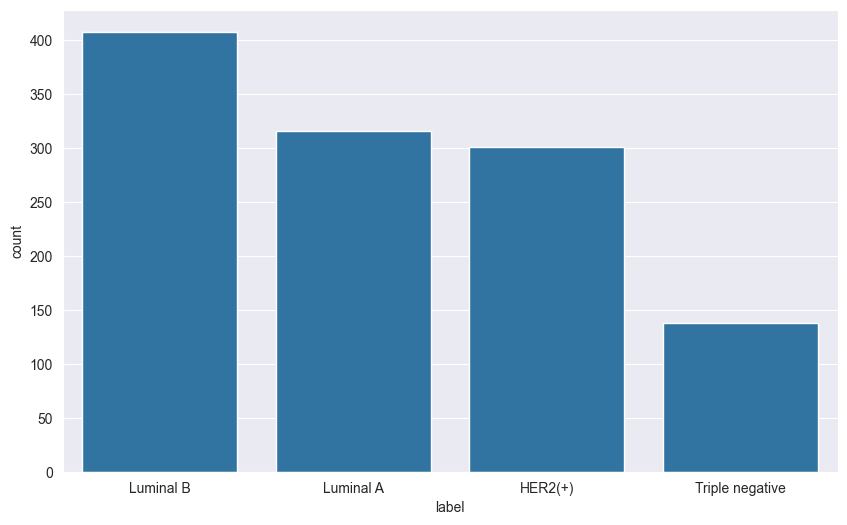

In [16]:
# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_labels, x='label', order=train_labels['label'].value_counts().index)

In [17]:
# Show image pixel sizes throughout dataset
sizes = []
for idx in train_labels['sample_index']:
    img = Image.open(train_dir + idx)
    sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])
print(sizes_df.describe())

             width       height
count  1163.000000  1163.000000
mean   1253.587274  1333.043852
std     446.656134   500.227756
min    1024.000000  1024.000000
25%    1024.000000  1024.000000
50%    1024.000000  1079.000000
75%    1294.000000  1462.000000
max    3970.000000  4233.000000


In [18]:
# Analyze image size distribution in train and test sets
import os

# Get all sizes from train set
train_sizes = []
for idx in train_labels['sample_index']:
    img = Image.open(train_dir + idx)
    train_sizes.append(img.size)

# Get all sizes from test set
test_files = os.listdir(test_dir)
test_sizes = []
for filename in test_files:
    img = Image.open(test_dir + filename)
    test_sizes.append(img.size)

# Create DataFrames
train_sizes_df = pd.DataFrame(train_sizes, columns=['width', 'height'])
test_sizes_df = pd.DataFrame(test_sizes, columns=['width', 'height'])

print("=== TRAIN SET IMAGE SIZES ===")
print(train_sizes_df.describe())
print(f"\nTotal train images: {len(train_sizes_df)}")
print(f"\nUnique sizes in train set: {train_sizes_df.value_counts()}")

print("\n=== TEST SET IMAGE SIZES ===")
print(test_sizes_df.describe())
print(f"\nTotal test images: {len(test_sizes_df)}")
print(f"\nUnique sizes in test set: {test_sizes_df.value_counts()}")

# Find the smallest dimensions
min_width_train = train_sizes_df['width'].min()
min_height_train = train_sizes_df['height'].min()
min_width_test = test_sizes_df['width'].min()
min_height_test = test_sizes_df['height'].min()

print(f"\n=== MINIMUM DIMENSIONS ===")
print(f"Train - Min width: {min_width_train}, Min height: {min_height_train}")
print(f"Test - Min width: {min_width_test}, Min height: {min_height_test}")
print(f"Overall minimum - Width: {min(min_width_train, min_width_test)}, Height: {min(min_height_train, min_height_test)}")

# Count how many images have non-standard sizes
most_common_size = tuple(train_sizes_df.mode().iloc[0])
print(f"\n=== SIZE VARIATION ANALYSIS ===")
print(f"Most common size in train: {most_common_size}")
non_standard_train = len(train_sizes_df[(train_sizes_df['width'] != most_common_size[0]) | 
                                         (train_sizes_df['height'] != most_common_size[1])])
print(f"Images with non-standard size in train: {non_standard_train} ({non_standard_train/len(train_sizes_df)*100:.2f}%)")

if len(test_sizes_df) > 0:
    most_common_size_test = tuple(test_sizes_df.mode().iloc[0])
    print(f"Most common size in test: {most_common_size_test}")
    non_standard_test = len(test_sizes_df[(test_sizes_df['width'] != most_common_size_test[0]) | 
                                          (test_sizes_df['height'] != most_common_size_test[1])])
    print(f"Images with non-standard size in test: {non_standard_test} ({non_standard_test/len(test_sizes_df)*100:.2f}%)")

=== TRAIN SET IMAGE SIZES ===
             width       height
count  1163.000000  1163.000000
mean   1253.587274  1333.043852
std     446.656134   500.227756
min    1024.000000  1024.000000
25%    1024.000000  1024.000000
50%    1024.000000  1079.000000
75%    1294.000000  1462.000000
max    3970.000000  4233.000000

Total train images: 1163

Unique sizes in train set: width  height
1024   1057      10
       1044       7
1134   1024       7
1024   1041       7
       1258       7
                 ..
1040   1024       1
1029   1024       1
3432   1024       1
3383   1024       1
2927   1024       1
Name: count, Length: 639, dtype: int64

=== TEST SET IMAGE SIZES ===
             width       height
count  1894.000000  1894.000000
mean   1271.655755  1324.171595
std     507.144348   509.719911
min    1024.000000  1024.000000
25%    1024.000000  1024.000000
50%    1024.000000  1072.000000
75%    1310.500000  1448.000000
max    6158.000000  4752.000000

Total test images: 1894

Unique size

=== DIMENSIONS BY LABEL ===
                 width                                                   \
                 count         mean         std     min     25%     50%   
label                                                                     
HER2(+)          301.0  1226.312292  420.664715  1024.0  1024.0  1024.0   
Luminal A        316.0  1236.094937  425.624662  1024.0  1024.0  1024.0   
Luminal B        408.0  1278.360294  464.299647  1024.0  1024.0  1024.0   
Triple negative  138.0  1279.891304  492.749750  1024.0  1024.0  1024.0   

                                 height               ...                   \
                     75%     max  count         mean  ...      75%     max   
label                                                 ...                    
HER2(+)          1238.00  3807.0  301.0  1370.318937  ...  1512.00  4233.0   
Luminal A        1272.75  3916.0  316.0  1339.196203  ...  1489.50  3593.0   
Luminal B        1380.25  3916.0  408.0  1309.659314  ..

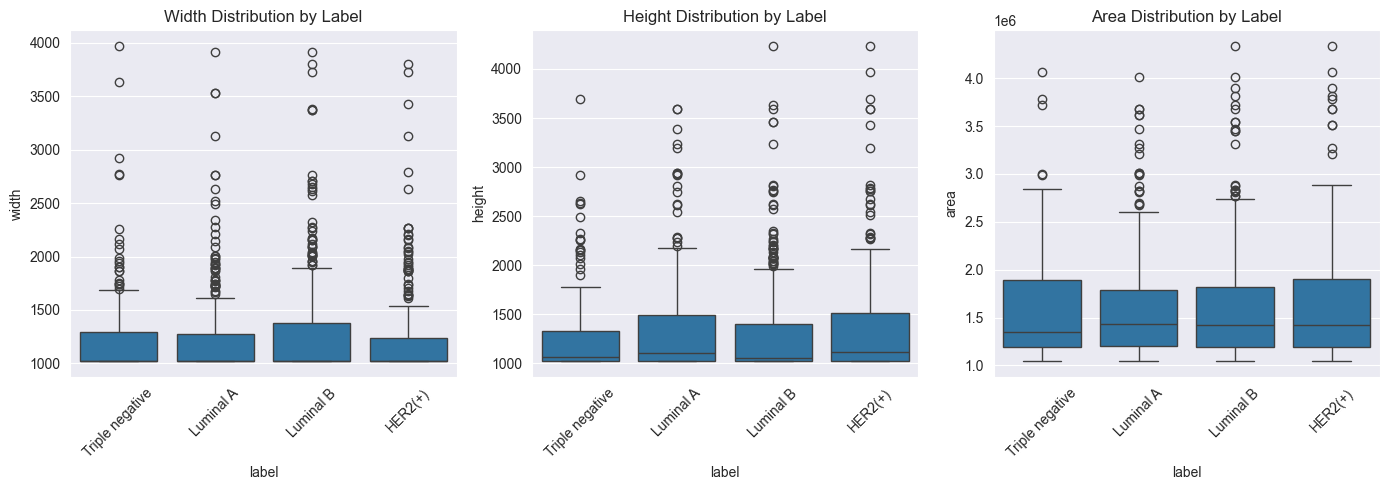


=== SIZE STATISTICS BY LABEL ===

Label HER2(+):
  Count: 301
  Width range: 1024 - 3807
  Height range: 1024 - 4233
  Unique sizes: 250

Label Luminal A:
  Count: 316
  Width range: 1024 - 3916
  Height range: 1024 - 3593
  Unique sizes: 264

Label Luminal B:
  Count: 408
  Width range: 1024 - 3916
  Height range: 1024 - 4233
  Unique sizes: 334

Label Triple negative:
  Count: 138
  Width range: 1024 - 3970
  Height range: 1024 - 3693
  Unique sizes: 124


In [19]:
# Analyze relationship between image dimensions and labels
train_sizes_with_labels = train_sizes_df.copy()
train_sizes_with_labels['label'] = train_labels['label'].values

# Calculate area
train_sizes_with_labels['area'] = train_sizes_with_labels['width'] * train_sizes_with_labels['height']

print("=== DIMENSIONS BY LABEL ===")
print(train_sizes_with_labels.groupby('label')[['width', 'height', 'area']].describe())

# Visualize width distribution by label
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=train_sizes_with_labels, x='label', y='width')
plt.title('Width Distribution by Label')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=train_sizes_with_labels, x='label', y='height')
plt.title('Height Distribution by Label')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=train_sizes_with_labels, x='label', y='area')
plt.title('Area Distribution by Label')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check if specific labels have different size patterns
print("\n=== SIZE STATISTICS BY LABEL ===")
for label in sorted(train_sizes_with_labels['label'].unique()):
    label_data = train_sizes_with_labels[train_sizes_with_labels['label'] == label]
    unique_sizes = label_data[['width', 'height']].value_counts()
    print(f"\nLabel {label}:")
    print(f"  Count: {len(label_data)}")
    print(f"  Width range: {label_data['width'].min()} - {label_data['width'].max()}")
    print(f"  Height range: {label_data['height'].min()} - {label_data['height'].max()}")
    print(f"  Unique sizes: {len(unique_sizes)}")
    if len(unique_sizes) <= 5:
        print(f"  All sizes:\n{unique_sizes}")